In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
import os
from pydantic import BaseModel, Field
import operator
from typing import Annotated, Literal
from langchain_core.messages import SystemMessage, HumanMessage

In [3]:
load_dotenv()

True

In [4]:
generator_llm = ChatOpenAI(model="gpt-4o-mini")
evaluator_llm = ChatOpenAI(model="gpt-4o-mini")
optimizer_llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
class TweetEvaluationSchema(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [6]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluationSchema)

In [7]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "rejected"]
    feedback: str
    iteration: int
    max_iterations: int
    
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [8]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [9]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [10]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [11]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iterations']:
        return 'approved'
    else:
        return 'rejected'

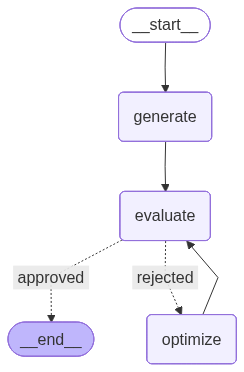

In [12]:
# Create graph
graph = StateGraph(TweetState)

# Add nodes
graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

# Add edges
graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'rejected': 'optimize'})
graph.add_edge('optimize', 'evaluate')

# Compile the graph
workflow = graph.compile()

workflow

# Tests

## Test 1 – Topic: AI productivity hacks
- iteration: 1
- max_iterations: 5


In [51]:
initial_state = {
    "topic": "AI productivity hacks",
    "iteration": 1,
    "max_iterations": 5
}

workflow.invoke(initial_state)


{'topic': 'AI productivity hacks',
 'tweet': 'Just tried one of those AI productivity hacks. You know, the ones that promise to make you work smarter? Turns out my biggest productivity boost was simply typing "I’m busy" into ChatGPT and taking a nap. Who knew being "highly efficient" could feel so cozy? 💤😴 #AIHacks',
 'evaluation': 'approved',
 'feedback': "This tweet showcases a good level of originality, presenting a humorous take on productivity hacks with a relatable twist. The humor is light and clever, likely eliciting a smile from readers who find themselves in similar situations of procrastination. It’s punchy and well-formatted, fitting perfectly within the character limit and avoiding traditional joke structures. The concept of using AI for productivity only to end up taking a nap also adds to its virality potential, as many would resonate with the juxtaposition of 'efficiency' and relaxation. Overall, it’s a well-crafted tweet that balances humor and relatability effectively

## Test 2 – Topic: Space exploration fails
- iteration: 1
- max_iterations: 5


In [13]:
initial_state = {
    "topic": "Space exploration fails",
    "iteration": 1,
    "max_iterations": 5
}

workflow.invoke(initial_state)


{'topic': 'Space exploration fails',
 'tweet': 'Another space probe lost contact? Makes sense—who wouldn\'t want to escape endless human drama? "Houston, we have a problem" beats "So, how’s dating on Earth?" any day! 🚀🙄 #SpaceFails #MissionImprobable',
 'evaluation': 'approved',
 'feedback': "This tweet showcases originality by linking space probes with human drama in a humorous way that feels fresh and relatable. The humor is clever, utilizing the contrast between the burdens of Earthly problems and the simplicity of space exploration, which can elicit a chuckle. It's punchy enough to grab attention quickly, with a sharp delivery that benefits from the well-placed emojis that enhance the tone. The combination of hashtags adds potential for virality as they tap into popular topics. It adheres to the tweet format guidelines—staying within character limits and avoiding setup-punchline structures.",
 'iteration': 2,
 'max_iterations': 5,
 'tweet_history': ['Just heard about another space 

## Test 3 – Topic: Coffee shop freelancing
- iteration: 1
- max_iterations: 5


In [53]:
initial_state = {
    "topic": "Coffee shop freelancing",
    "iteration": 1,
    "max_iterations": 5
}

workflow.invoke(initial_state)


{'topic': 'Coffee shop freelancing',
 'tweet': 'Freelancing at a coffee shop: where your biggest decisions are whether to order a cappuccino or a latte, and if that barista is judging your 3rd refill. Meanwhile, the only thing getting paid is my anxiety and the wi-fi bill. ☕️💻 #CoffeeShopChronicles',
 'evaluation': 'approved',
 'feedback': "This tweet stands out with its originality, as the theme of freelancing in a coffee shop is relatable yet refreshing. The humor strikes a chord with many who have experienced the anxiety of working in a public space, particularly the way it frames the decisions about coffee alongside the struggle of freelancing. It’s punchy and efficient, capturing the essence in a concise manner that invites sharing. Additionally, it has great virality potential, likely resonating with a wide audience of freelancers and coffee lovers alike. Overall, it's a well-formatted tweet that effectively conveys humor and relatability.",
 'iteration': 1,
 'max_iterations': 5,

## Test 4 – Topic: Crypto market memes
- iteration: 1
- max_iterations: 5


In [54]:
initial_state = {
    "topic": "Crypto market memes",
    "iteration": 1,
    "max_iterations": 5
}

workflow.invoke(initial_state)


{'topic': 'Crypto market memes',
 'tweet': 'Crypto market memes are like my morning coffee—full of volatility and occasionally make me question my life choices. One minute I’m up, the next I’m staring at my portfolio like it just graduated from a clown college 🎪📉. Cheers to “investing” in memes! #HODL 😂💸',
 'evaluation': 'approved',
 'feedback': "This tweet strikes a nice balance between humor and relatability, cleverly comparing the volatility of the crypto market to the unpredictability of life choices, which many can identify with. The use of emojis adds a visual layer that enhances the humor without overwhelming the message. While the concept of combining crypto and memes isn't entirely new, the execution here is fresh and engaging. The tweet is concise and fits well within the character limit, making it catchy and shareable. Overall, it's a well-constructed tweet that has good potential for virality.",
 'iteration': 1,
 'max_iterations': 5,
 'tweet_history': ['Crypto market memes 

## Test 5 – Topic: Remote work parenting
- iteration: 1
- max_iterations: 5


In [55]:
initial_state = {
    "topic": "Remote work parenting",
    "iteration": 1,
    "max_iterations": 5
}

workflow.invoke(initial_state)


{'topic': 'Remote work parenting',
 'tweet': "Juggling remote work and parenting feels like trying to assemble IKEA furniture while on a conference call and a toddler's meltdown is the background music. Spoiler: the only thing I'll build today is a fort out of my deadlines. 🏰📞 #WorkFromHomeLife #ParentingWin",
 'evaluation': 'approved',
 'feedback': "This tweet showcases originality by likening the chaos of remote work and parenting to the relatable experience of assembling IKEA furniture, which injects humor into a common struggle. The comparison creates a vivid mental image that is both amusing and relatable, making it likely to resonate with a wide audience. The humor is genuine, as it captures the absurdity of multitasking in the midst of distractions. Its punchiness is enhanced by the concise structure, and it stays within Twitter's character limit while effectively using emojis for added flair. Overall, it has strong virality potential due to its relatable content and humorous ex

## Test 6 – Topic: AI productivity hacks
- iteration: 1
- max_iterations: 5

In [1]:
initial_state = {
    "topic": "AI productivity hacks",
    "iteration": 1,
    "max_iterations": 5
}

workflow.invoke(initial_state)

NameError: name 'workflow' is not defined

In [14]:
print("Hello World")

Hello World


In [15]:
initial_state = {
    "topic": "AI productivity hacks",
    "iteration": 1,
    "max_iterations": 5
}

workflow.invoke(initial_state)

{'topic': 'AI productivity hacks',
 'tweet': 'Just unleashed my robot vacuum as my new productivity guru. While it cleans, I’m mastering the fine art of existential dread. Who knew procrastination could be so... organized? 🤖✨ #WorkSmarter #MessyMindset ',
 'evaluation': 'approved',
 'feedback': "This tweet is quite original, cleverly combining the concept of a robot vacuum with productivity and existential dread, giving it a fresh perspective. The humor is subtle yet effective, provoking a chuckle with the idea of procrastination being 'organized.' It maintains a concise format while still delivering a thoughtful message, which adds to its punchiness. The hashtags fit well and enhance its virality potential, making it shareable for those who relate to the struggle of balancing productivity with procrastination.",
 'iteration': 3,
 'max_iterations': 5,
 'tweet_history': ['Just discovered AI productivity hacks! Apparently, one of them is letting my robot vacuum handle my life. Now my flo